# Customer Segmentation Using Clustering

## **Table of Contents**
1. [Project Overview](#1-project-overview)
2. [Installing and Importing Libraries](#2-installing-and-importing-libraries)
3. [Loading and Inspecting the Dataset](#3-loading-and-inspecting-the-dataset)
4. [Data Cleaning](#4-cata-cleaning)
5. [Feature Engineering](#5-feature-engineering)
6. [Exploratory Data Analysis (EDA)](#6-exploratory-data-analysis-eda)
7. [Feature Scaling](#7-feature-scaling)
8. [Determining Optimal Clusters (K)](#8-determining-optimal-clusters-k)
9. [Hierarchical Clustering (Dendrogram)](#9-hierarchical-clustering-dendrogram)
10. [Applying K-Means Clustering](#10-applying-k-means-clustering)
11. [Dimensionality Reduction (PCA & t-SNE)](#11-dimensionality-reduction-pca--t-sne)
12. [Cluster Profiling & Insights](#12-cluster-profiling--insights)
13. [Conclusion](#13-conclusion)




## 1. Project Overview
This project applies unsupervised machine learning techniques to segment customers based on their purchasing behaviour. The goal is to identify distinct customer groups to enhance targeted marketing strategies.

## 2. Installing and Importing Required Libraries

In [ ]:
#Installing Libraries
!pip install gdown
!gdown 'https://drive.google.com/uc?export=download&id=1S5wniOV5_5htDfUFeZhlCLibvtihNLKK'

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1S5wniOV5_5htDfUFeZhlCLibvtihNLKK
From (redirected): https://drive.google.com/uc?export=download&id=1S5wniOV5_5htDfUFeZhlCLibvtihNLKK&confirm=t&uuid=527bd6f8-f03e-4569-af83-781f5afef633
To: /content/CUSTOMERS_CLEAN.csv
100% 191M/191M [00:03<00:00, 58.9MB/s]


In [ ]:
# Importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.stats.mstats import winsorize
import warnings

# Suppressing warnings for clean output
warnings.filterwarnings('ignore')

## 3. Loading and Inspecting the Dataset

In [ ]:
# Loading dataset from provided URL
url = "CUSTOMERS_CLEAN.csv"
df = pd.read_csv(url)

# Displaying first few rows of the dataset
df.head()

,Quantity,City,Continent,Postal_Code,State_Province,Order_Date,Delivery_Date,Total Revenue,Unit Cost,Discount,OrderTypeLabel,CustomerCountryLabel,Customer_BirthDate,Customer_Group,Customer_Type,Order ID,Profit,Days to Delivery,Loyalty Num,Customer ID
0,3,Leinster,Oceania,6437,Western Australia,01JAN2012,07JAN2012,$28.50,$9.10,.,Internet Sale,Australia,08MAY1978,Internet/Catalog Customers,Internet/Catalog Customers,1230000033,$1.20,6,99,8818
1,2,Berowra,Oceania,2081,New South Wales,01JAN2012,04JAN2012,$113.40,$56.90,.,Internet Sale,Australia,13DEC1978,Orion Club Gold members,Orion Club Gold members high activity,1230000204,($0.40),3,99,47793
2,2,Berowra,Oceania,2081,New South Wales,01JAN2012,04JAN2012,$41.00,$18.50,.,Internet Sale,Australia,13DEC1978,Orion Club Gold members,Orion Club Gold members high activity,1230000204,$4.00,3,99,47793
3,1,Northbridge,Oceania,2063,New South Wales,01JAN2012,03JAN2012,$35.20,$29.60,.,Internet Sale,Australia,22JUN1997,Orion Club Gold members,Orion Club Gold members high activity,1230000268,$5.60,2,0,71727
4,1,Montréal,North America,NaN,Quebec,01JAN2012,04JAN2012,$24.70,$23.60,.,Internet Sale,Canada,28JAN1978,Orion Club Gold members,Orion Club Gold members medium activity,1230000487,$1.10,3,99,74503


In [ ]:
# Checking for missing values
print(df.isnull().sum())

# Checking for duplicate rows
print(df.duplicated().sum())

Quantity                     0
City                       135
Continent                    0
Postal_Code               3716
State_Province          117192
Order_Date                   0
Delivery_Date                0
Total Revenue                0
Unit Cost                    0
Discount                     0
OrderTypeLabel               0
CustomerCountryLabel         0
Customer_BirthDate           0
Customer_Group               0
Customer_Type                0
Order ID                     0
Profit                       0
Days to Delivery             0
Loyalty Num                  0
Customer ID                  0
dtype: int64
21


## 4. Data Cleaning
### Handling Missing Values and Duplicates

In [ ]:
# Filling missing values in categorical columns
df['City'].fillna('Unknown', inplace=True)
df['Postal_Code'].fillna('Unknown', inplace=True)
df['State_Province'].fillna('Unknown', inplace=True)

# Removing duplicate rows
df.drop_duplicates(inplace=True)

### Converting Data Types

In [ ]:
# Converting financial columns to float
df['Total Revenue'] = df['Total Revenue'].replace({'\$': '', ',': ''}, regex=True).astype(float)
df['Unit Cost'] = df['Unit Cost'].replace({'\$': '', ',': ''}, regex=True).astype(float)
df['Profit'] = df['Profit'].replace({'\(': '-', '\)': '', '\$': '', ',': ''}, regex=True).astype(float)

# Converting date columns to datetime format
df['Order_Date'] = pd.to_datetime(df['Order_Date'], errors='coerce')
df['Customer_BirthDate'] = pd.to_datetime(df['Customer_BirthDate'], errors='coerce')

# Displaying dataset information after cleaning
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 951648 entries, 0 to 951668
Data columns (total 20 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Quantity              951648 non-null  int64         
 1   City                  951648 non-null  object        
 2   Continent             951648 non-null  object        
 3   Postal_Code           951648 non-null  object        
 4   State_Province        951648 non-null  object        
 5   Order_Date            951648 non-null  datetime64[ns]
 6   Delivery_Date         951648 non-null  object        
 7   Total Revenue         951648 non-null  float64       
 8   Unit Cost             951648 non-null  float64       
 9   Discount              951648 non-null  object        
 10  OrderTypeLabel        951648 non-null  object        
 11  CustomerCountryLabel  951648 non-null  object        
 12  Customer_BirthDate    951648 non-null  datetime64[ns]
 13  Cust

## 5. Feature Engineering



### Creating New Features for Customer Segmentation

In [ ]:
# Computing customer segmentation metrics
frequency_df = df.groupby('Customer ID').size().reset_index(name='Frequency')
recency_df = df.groupby('Customer ID').agg({'Order_Date': lambda x: (df['Order_Date'].max() - x.max()).days}).reset_index().rename(columns={'Order_Date': 'Recency'})
clv_df = df.groupby('Customer ID').agg({'Total Revenue': 'sum'}).reset_index().rename(columns={'Total Revenue': 'CLV'})
avg_unit_cost_df = df.groupby('Customer ID').agg({'Unit Cost': 'mean'}).reset_index().rename(columns={'Unit Cost': 'Avg_Unit_Cost'})
customer_age_df = df.groupby('Customer ID').agg({'Customer_BirthDate': lambda x: (pd.Timestamp.now().year - x.dt.year.max())}).reset_index().rename(columns={'Customer_BirthDate': 'Customer_Age'})

# Merging all engineered features
df_features = pd.DataFrame(df['Customer ID'].unique(), columns=['Customer ID'])
for feature_df in [frequency_df, recency_df, clv_df, avg_unit_cost_df, customer_age_df]:
    df_features = df_features.merge(feature_df, on='Customer ID')

# Displaying new feature set
df_features.head()

,Customer ID,Frequency,Recency,CLV,Avg_Unit_Cost,Customer_Age
0,8818,31,381,3732.7,60.206452,47
1,47793,20,141,2166.3,66.280000,47
2,71727,20,71,2566.0,74.775000,28
3,74503,6,756,1156.3,74.300000,47
4,8610,3,298,638.0,183.866667,62


## 6. Exploratory Data Analysis (EDA)

### Identifying and Handling Outliers

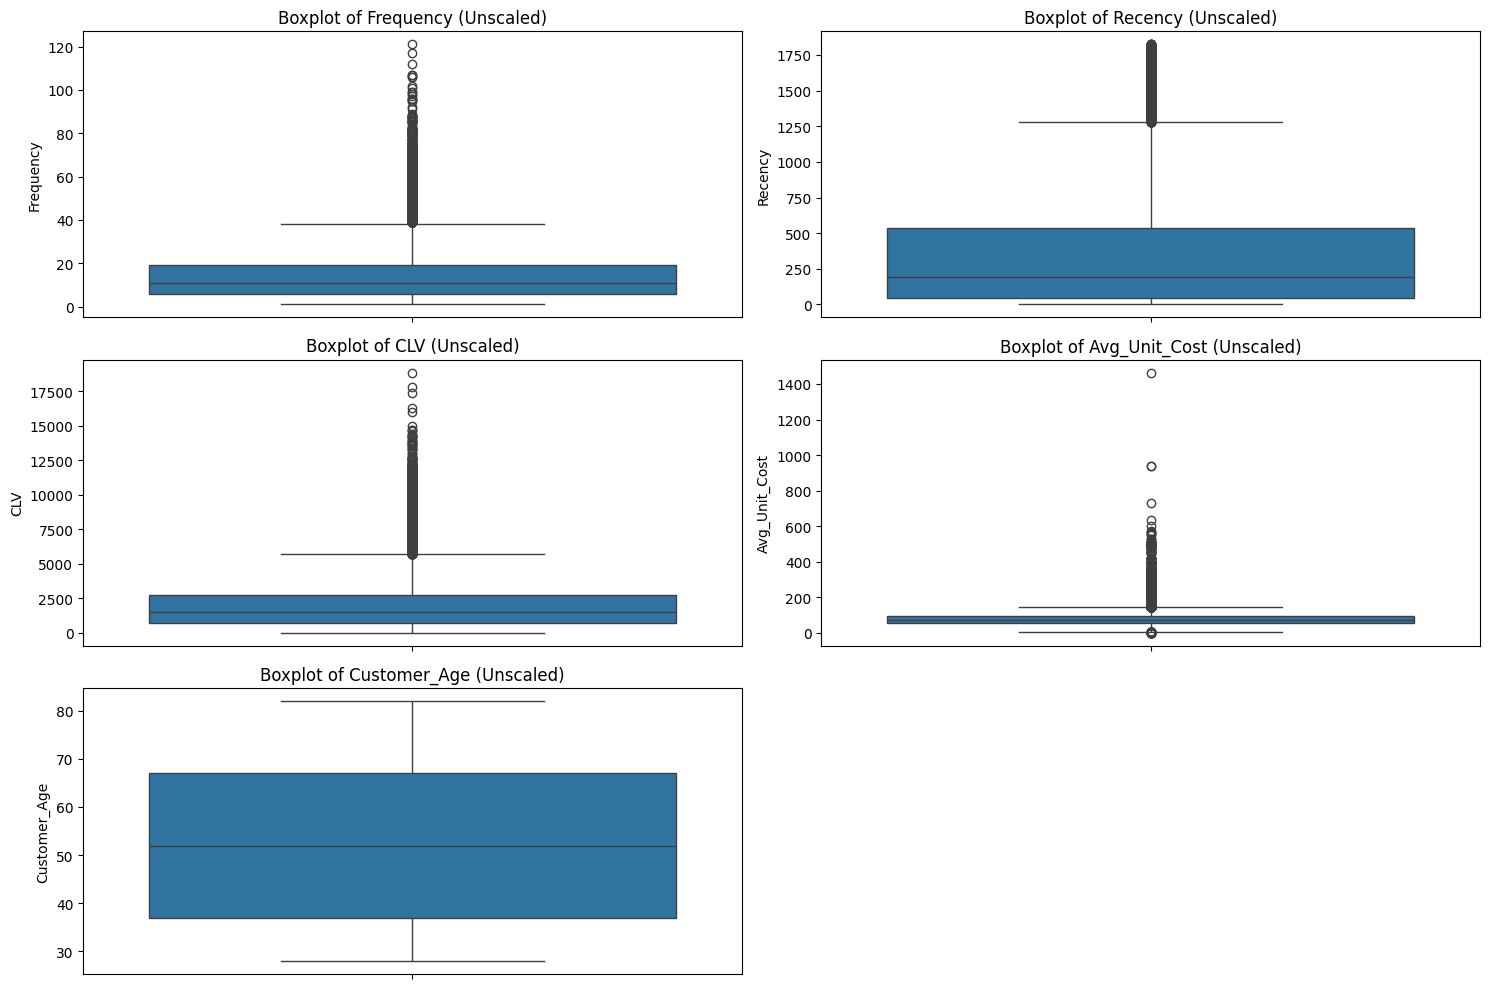

In [ ]:
# Plotting boxplots to check for outliers
plt.figure(figsize=(15, 10))
features = ['Frequency', 'Recency', 'CLV', 'Avg_Unit_Cost', 'Customer_Age']
for i, feature in enumerate(features, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(y=df_features[feature])
    plt.title(f'Boxplot of {feature} (Unscaled)')
plt.tight_layout()
plt.show()

### **Observations from Outlier Analysis**
- The boxplots indicate that **Frequency, CLV, and Avg_Unit_Cost** contain extreme outliers.
- Winsorization is applied to **cap extreme values** without removing key data points.
- Recency and Customer_Age distributions appear reasonable and do not require transformation.

### Applying Winsorization for Extreme Outliers

In [ ]:
# Applying Winsorization to cap extreme outliers
df_features['Frequency'] = winsorize(df_features['Frequency'], limits=[0, 0.05])
df_features['CLV'] = winsorize(df_features['CLV'], limits=[0, 0.05])
df_features['Avg_Unit_Cost'] = winsorize(df_features['Avg_Unit_Cost'], limits=[0, 0.05])

## 7. Feature Scaling

In [ ]:
# Applying Standard Scaling
scaler = StandardScaler()
features_to_scale = ['Frequency', 'Recency', 'CLV', 'Avg_Unit_Cost', 'Customer_Age']
df_features_scaled = df_features.copy()
df_features_scaled[features_to_scale] = scaler.fit_transform(df_features[features_to_scale])

# Displaying scaled features
df_features_scaled.head()

,Customer ID,Frequency,Recency,CLV,Avg_Unit_Cost,Customer_Age
0,8818,1.822041,0.032177,1.271674,-0.578203,-0.292081
1,47793,0.682953,-0.546822,0.202423,-0.362006,-0.292081
2,71727,0.682953,-0.715697,0.475265,-0.059613,-1.379519
3,74503,-0.766796,0.936864,-0.487020,-0.076521,-0.292081
4,8610,-1.077457,-0.168060,-0.840820,2.211545,0.566422


## 8. Determining Optimal Number of Clusters (K)

### Using the Elbow Method and Silhouette Score

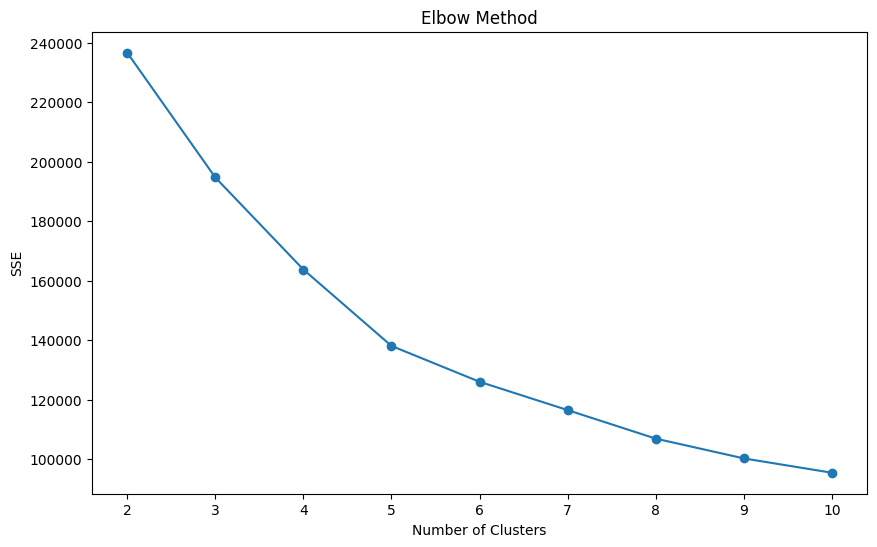

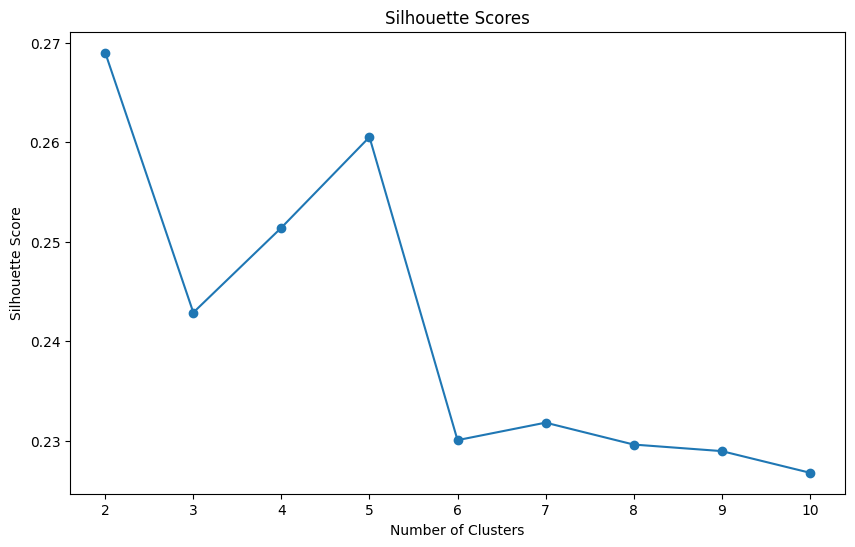

In [ ]:
# Determining optimal K using Elbow Method and Silhouette Score
sse = []
silhouette_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_features_scaled[features_to_scale])
    sse.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(df_features_scaled[features_to_scale], kmeans.labels_))

# Plotting Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), sse, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.show()

# Plotting Silhouette Scores
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Scores')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

### **Choosing the Optimal Number of Clusters (K)**
- The **Elbow Method suggests K=5**, as SSE starts to level off at this point.
- The **Silhouette Score is also highest for K=5**, meaning clusters are well-separated.
- This confirms that **K=5 is a strong choice** for segmentation.

## 9. Hierarchical Clustering (Dendrogram)

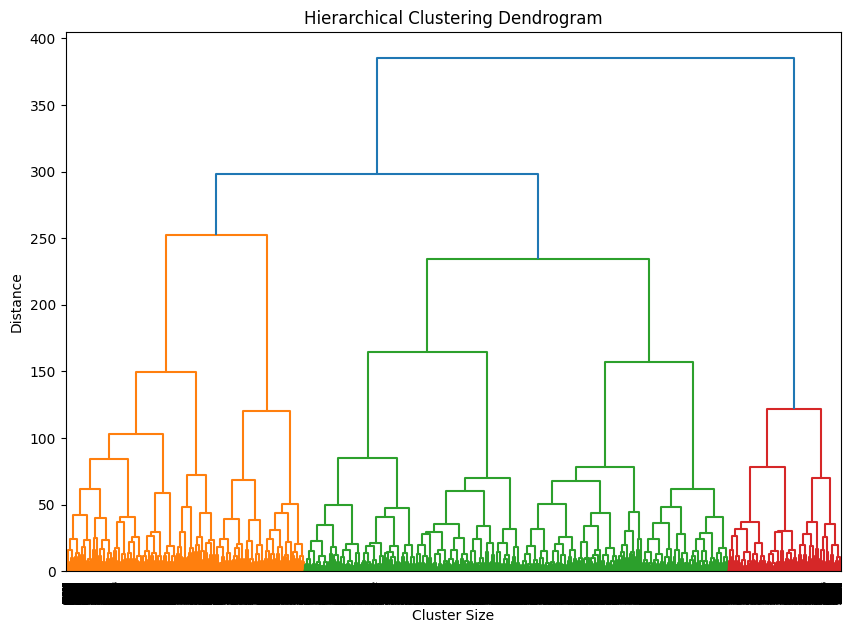

In [ ]:
 # Creating dendrogram for hierarchical clustering
linked = linkage(df_features_scaled[features_to_scale], 'ward')

plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Cluster Size')
plt.ylabel('Distance')
plt.show()

### **Interpreting the Dendrogram**
- The **hierarchical clustering dendrogram supports K=5**, as there are clear breaks at this level.
- This confirms that **the customer segments are naturally separable**.
- The results align with the Elbow and Silhouette methods, validating our choice.


## 10. Applying K-Means Clustering (K=5)

In [ ]:
# Applying K-Means with chosen K=5
kmeans = KMeans(n_clusters=5, random_state=42)

# Assigning cluster labels
df_features_scaled['Cluster'] = kmeans.fit_predict(df_features_scaled[features_to_scale]) + 1

## 11. Dimensionality Reduction (PCA & t-SNE)

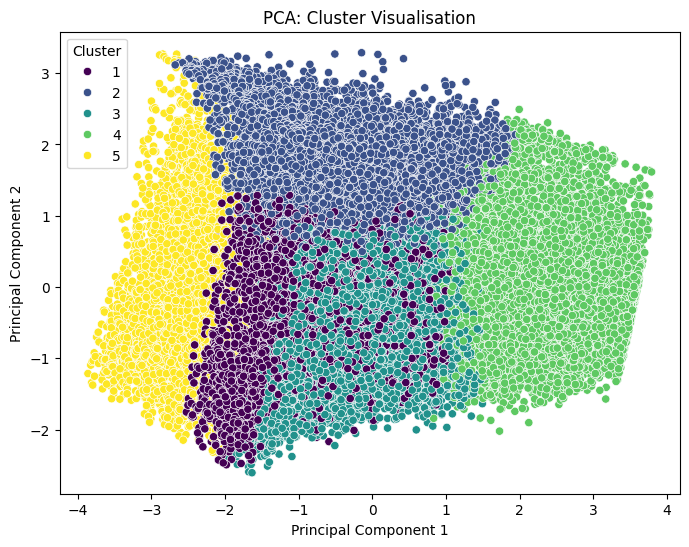

In [ ]:
# Applying PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_features_scaled[features_to_scale])

# Adding PCA results to the DataFrame
df_features_scaled['PCA1'], df_features_scaled['PCA2'] = pca_result[:, 0], pca_result[:, 1]

# Visualising PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=df_features_scaled, palette='viridis')
plt.title('PCA: Cluster Visualisation')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

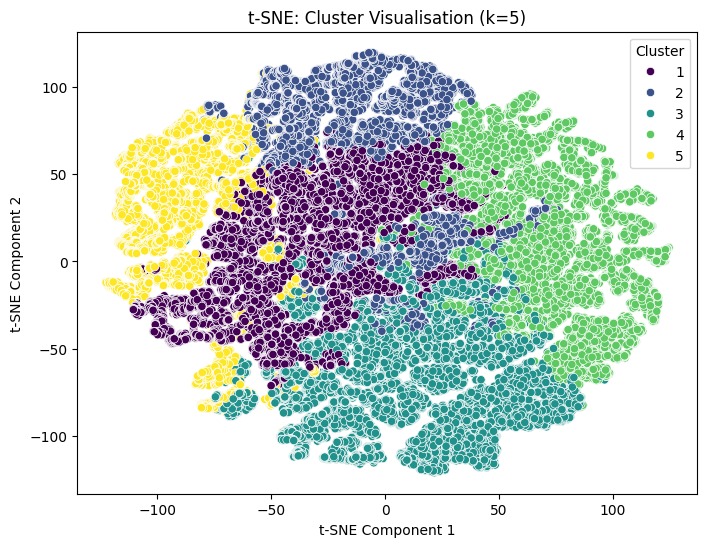

In [ ]:
# Applying t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(df_features_scaled[features_to_scale])

# Adding t-SNE results to the DataFrame
df_features_scaled['tSNE1'], df_features_scaled['tSNE2'] = tsne_result[:, 0], tsne_result[:, 1]

# Visualising t-SNE results
plt.figure(figsize=(8, 6))
sns.scatterplot(x='tSNE1', y='tSNE2', hue='Cluster', data=df_features_scaled, palette='viridis')
plt.title('t-SNE: Cluster Visualisation (k=5)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Cluster')
plt.show()


## 12. Cluster Profiling

In [ ]:
# Inverse transform the scaled data to get back original values
df_features_scaled[['Frequency', 'Recency', 'CLV', 'Avg_Unit_Cost', 'Customer_Age']] = scaler.inverse_transform(
    df_features_scaled[['Frequency', 'Recency', 'CLV', 'Avg_Unit_Cost', 'Customer_Age']]
)

# Display first few rows to confirm changes
df_features_scaled.head()

,Customer ID,Frequency,Recency,CLV,Avg_Unit_Cost,Customer_Age,Cluster,PCA1,PCA2,tSNE1,tSNE2
0,8818,31.0,381.0,3732.7,60.206452,47.0,4,1.818191,-0.750546,85.716583,5.170779
1,47793,20.0,141.0,2166.3,66.280000,47.0,3,0.759002,-0.614735,30.816082,-35.551842
2,71727,20.0,71.0,2566.0,74.775000,28.0,3,1.262531,-0.427279,71.288681,-69.780548
3,74503,6.0,756.0,1156.3,74.300000,47.0,5,-1.123804,0.252822,-45.737453,-19.727581
4,8610,3.0,298.0,638.0,138.577778,62.0,2,-0.791354,2.166504,9.723541,113.266083


In [ ]:
# Grouping by cluster to compute summary statistics
cluster_summary = df_features_scaled.groupby('Cluster')[['Frequency', 'Recency', 'CLV', 'Avg_Unit_Cost', 'Customer_Age']].agg(['mean', 'median', 'min', 'max'])

# Displaying summary statistics
pd.set_option("display.float_format", "{:.2f}".format)
cluster_summary

Frequency                    Recency                            CLV  \
             mean median   min   max    mean  median    min     max    mean   
Cluster                                                                       
1           10.35  10.00  1.00 30.00  229.59  152.00   0.00 1158.00 1219.50   
2            7.29   7.00  1.00 22.00  491.55  417.00   0.00 1799.00 1625.07   
3           11.75  12.00  1.00 30.00  235.92  146.00   0.00 1212.00 1397.73   
4           27.69  27.00 10.00 36.00  130.70   49.00   0.00 1472.00 4063.11   
5            4.66   4.00  1.00 28.00 1143.72 1127.00 386.00 1824.00  509.75   

                                Avg_Unit_Cost                      \
         median     min     max          mean median   min    max   
Cluster                                                             
1       1124.40    3.00 4005.60         64.50  64.86  1.60 115.55   
2       1466.80   87.70 5307.14        122.03 123.26 81.40 138.58   
3       1369.55    2.30 3675.10         66.49  66.58  1.20 115.42   
4       3978.89 1750.70 5307.14         82.23  79.93 32.85 138.58   
5        356.10    0.63 4407.48         56.93  55.90  0.50 138.58   

        Customer_Age                     
                mean median   min   max  
Cluster                                  
1              69.42  72.00 52.00 82.00  
2              52.87  52.00 28.00 82.00  
3              36.65  32.00 28.00 53.00  
4              47.99  47.00 28.00 82.00  
5              57.10  57.00 28.00 82.00

### **Customer Cluster Insights**
- **Cluster 1**: Loyal, frequent buyers with moderate spending.
- **Cluster 2**: Premium buyers who purchase less often but spend more per item.
- **Cluster 3**: Young, high-engagement customers who spend at a mid-range level.
- **Cluster 4**: The most valuable customers—frequent, high-value buyers.
- **Cluster 5**: Dormant customers—low engagement and low spending.

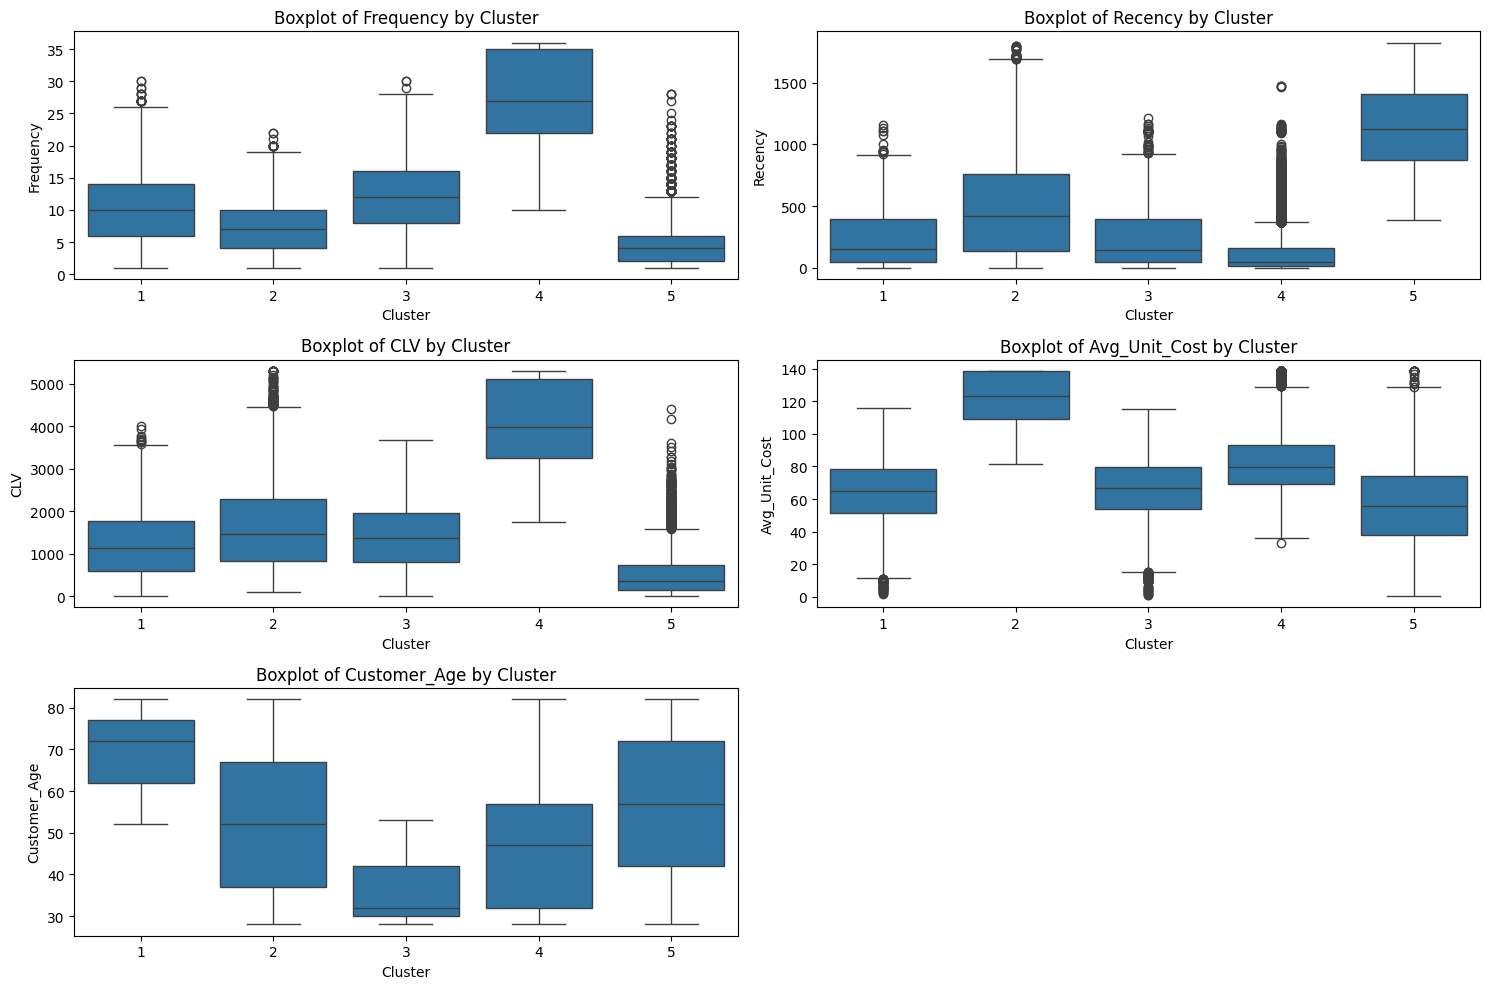

In [ ]:
# Plotting feature distributions across clusters
features_to_plot = ['Frequency', 'Recency', 'CLV', 'Avg_Unit_Cost', 'Customer_Age']
plt.figure(figsize=(15, 10))

for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(x='Cluster', y=feature, data=df_features_scaled)
    plt.title(f'Boxplot of {feature} by Cluster')

plt.tight_layout()
plt.show()

### **Key Takeaways from Cluster Distribution**
- **Cluster 4 has the highest spending and frequency**, making them the most valuable.
- **Cluster 5 has the lowest engagement**, indicating potential churn risk.
- **Cluster 2 prefers high-value items but shops less frequently**, which may require a different marketing approach.


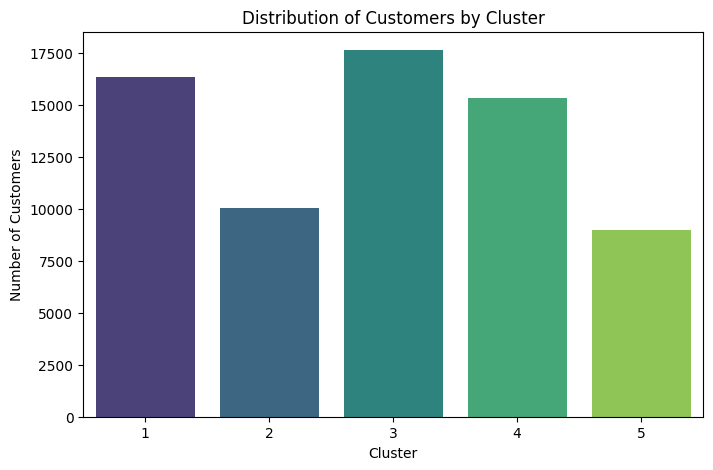

In [ ]:
# Counting the number of customers in each cluster
plt.figure(figsize=(8, 5))
sns.countplot(x='Cluster', data=df_features_scaled, palette='viridis')
plt.title('Distribution of Customers by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.show()

### **Cluster Size Distribution**
- Clusters **1, 3, and 4** have the highest number of customers (~15,000–18,000 each).
- Cluster **2 has fewer customers (~10,000)**, likely due to its premium nature.
- Cluster **5 is the smallest (~7,500 customers)**, representing the least engaged segment.
- **The distribution is well-balanced**, ensuring meaningful segmentation.

## 13. Conclusion

- The customer segmentation analysis identified **five distinct customer groups** using **K-Means clustering (K=5)**, validated by the **Elbow Method, Silhouette Score, and Dendrogram analysis**.  
- **Winsorization** was applied to mitigate extreme outliers, and **Standard Scaling** ensured fair feature weighting.  
- **PCA and t-SNE visualisations** confirmed that the clusters were meaningfully separated.  
- The segmentation results provide actionable insights for targeted marketing strategies.  